# Calling the Instance Segmentation deployed model

In [1]:
import base64
import json
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import os
import ssl
import warnings

from IPython.display import Image
from matplotlib.lines import Line2D
from PIL import Image as PILimage

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import sys

sys.version

'3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]'

In [3]:
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

In [4]:
def get_predictions(image_file):
    """
    Getting predictions
    """
    data =  {
        "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(image_file)).decode("utf-8")],
      }
    }

    body = str.encode(json.dumps(data))

    if not key:
        raise Exception("A key should be provided to invoke the endpoint")

    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ key),
               'azureml-model-deployment': 'instance-mlflow-model-dpl' }
    req = urllib.request.Request(endpoint, body, headers)

    try:
        response = urllib.request.urlopen(req)
        resp = response.read()

        return resp

    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))

In [5]:
def view_predictions(image_file, minconf=0.5, ndec=5):
    """
    Viewing predictions
    """
    img_np = mpimg.imread(image_file)
    img = PILimage.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size

    fig, ax = plt.subplots(1, figsize=(15, 15))

    ax.imshow(img_np)
    nb_product = 1
    
    print("\033[1;31;34m")
    print("AutoML for instance segmentation results:\n")

    detections = json.loads(resp)[0]

    for detect in detections["boxes"]:
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]

        if conf_score >= minconf:
            ymin, xmin, ymax, xmax = (
                box["topY"],
                box["topX"],
                box["bottomY"],
                box["bottomX"],
            )
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)
            print(nb_product, "label:", label, "=", round(conf_score, ndec))
        
            if label == 'carton':
                color = "brown"
                markercolor = "white"

            if label == 'milk_bottle':
                label = "milk"
                color = "lime"
                markercolor = "purple"

            if label == 'water_bottle':
                label = 'water'
                color = "cyan"
                markercolor = "blue"
        
            if label == 'can':
                label = 'soda can'
                color = "orange"
                markercolor = "red"
            
            polygon_np = np.array(polygon[0])
            polygon_np = polygon_np.reshape(-1, 2)
            polygon_np[:, 0] *= x
            polygon_np[:, 1] *= y
            
            # Displaying polygon
            poly = patches.Polygon(polygon_np,
                                   True,
                                   facecolor=color,
                                   alpha=0.6)
            ax.add_patch(poly)
            poly_line = Line2D(
                polygon_np[:, 0],
                polygon_np[:, 1],
                linewidth=2,
                marker="o",
                markersize=10,
                color=color,
                markerfacecolor=markercolor,
            )
            ax.add_line(poly_line)
            
            # print results on the image for each object
            plt.text(np.min(polygon_np),
                     np.max(polygon_np)+25,
                     label + " = " + str(round(conf_score, ndec)),
                     color=color, fontsize=20)

            nb_product += 1

    # Top results
    plt.text(25, 25, "Number of products = " + str(nb_product-1),
                     color="red", fontsize=25)

    # Saving image
    plt.savefig("results_" + os.path.basename(image_file))

    plt.axis('off')
    plt.show()

## Credentials

In [6]:
from configparser import ConfigParser

configazurecs = ConfigParser()
print("Reading Instance segmentation deployed managed endpoints credentials from a file...")
print(configazurecs.read('instsegmodel.py'))

key = configazurecs['InstanceSegModel']['key']
endpoint = configazurecs['InstanceSegModel']['endpoint']

print("\nDone")

Reading Instance segmentation deployed managed endpoints credentials from a file...
['instsegmodel.py']

Done


## Testing

In [7]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "2.jpg")

resp = get_predictions(sample_image)
print(resp)

b'[{"filename": "/tmp/tmpsdrhey42/tmp9n1i559e", "boxes": [{"box": {"topX": 0.0, "topY": 0.010956239566248829, "bottomX": 0.7136763666986077, "bottomY": 0.7388230728678538}, "label": "milk_bottle", "score": 0.9975250363349915, "polygon": [[0.574468085106383, 0.7347703842549204, 0.5481852315394243, 0.7319587628865979, 0.5306633291614519, 0.7188378631677601, 0.523153942428035, 0.7160262417994376, 0.5168961201501877, 0.7104029990627929, 0.5106382978723404, 0.7010309278350515, 0.5018773466833542, 0.6663542642924086, 0.4918648310387985, 0.647610121836926, 0.49436795994993743, 0.6204311152764761, 0.5081351689612015, 0.569821930646673, 0.509386733416771, 0.5473289597000938, 0.509386733416771, 0.514526710402999, 0.5031289111389237, 0.492970946579194, 0.4981226533166458, 0.46485473289597, 0.5031289111389237, 0.45454545454545453, 0.5081351689612015, 0.43486410496719774, 0.5181476846057572, 0.4189315838800375, 0.5294117647058824, 0.40581068416119964, 0.5356695869837297, 0.3908153701968135, 0.53566


AutoML for instance segmentation results:

1 label: milk_bottle = 0.99753


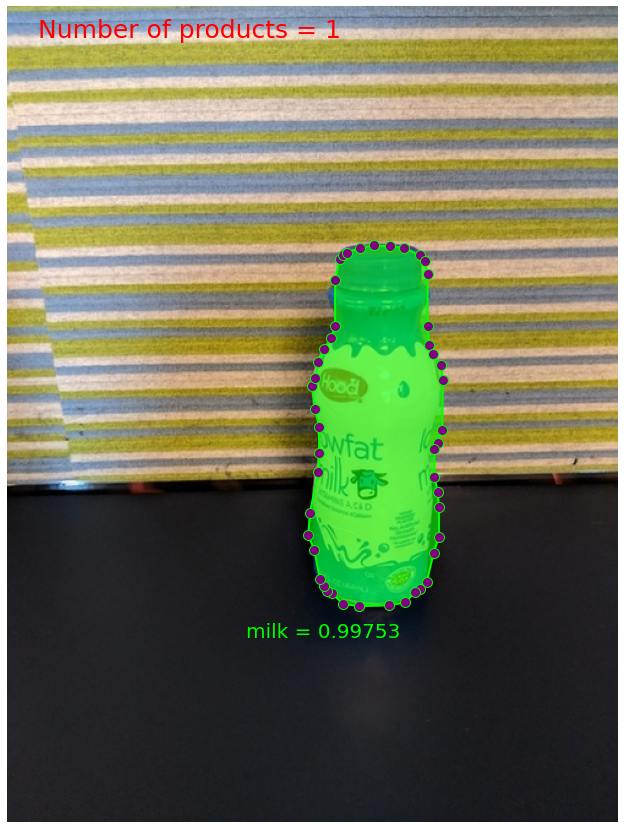

In [8]:
view_predictions(sample_image, minconf=0.8)


AutoML for instance segmentation results:

1 label: carton = 0.99871
2 label: milk_bottle = 0.94849


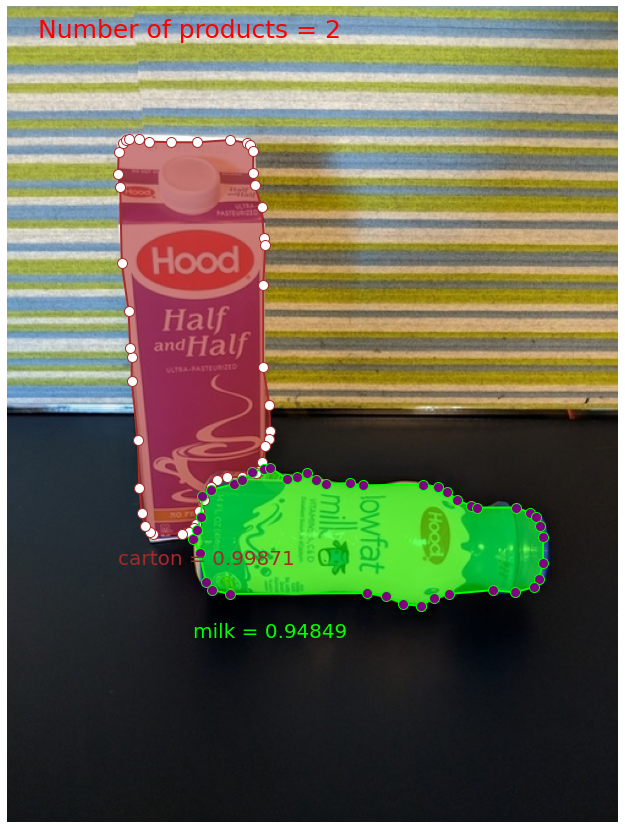

In [9]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "10.jpg")

resp = get_predictions(sample_image)
view_predictions(sample_image, minconf=0.8)


AutoML for instance segmentation results:

1 label: carton = 0.998
2 label: water_bottle = 0.981
3 label: can = 0.967


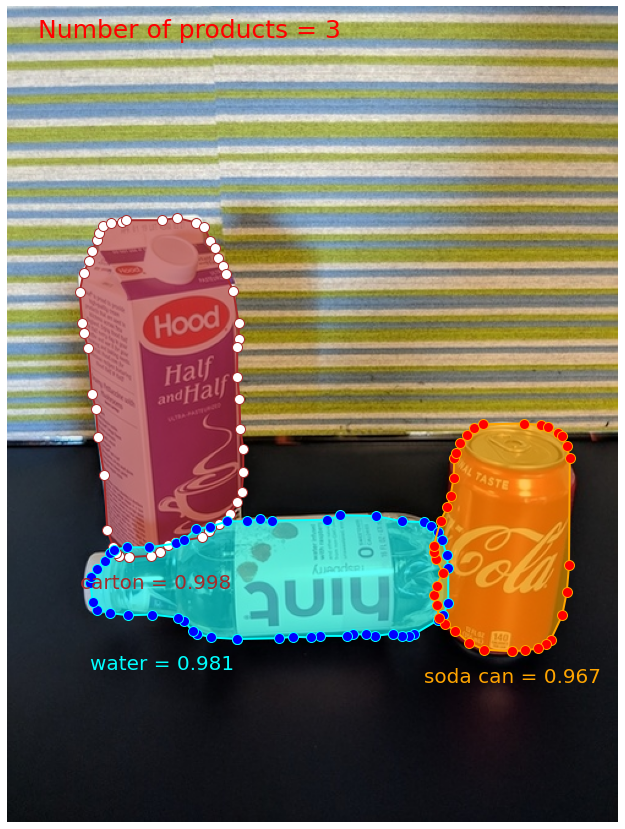

In [10]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "50.jpg")

resp = get_predictions(sample_image)
view_predictions(sample_image, minconf=0.8, ndec=3)


AutoML for instance segmentation results:

1 label: carton = 0.98903
2 label: can = 0.97951
3 label: water_bottle = 0.96483
4 label: milk_bottle = 0.96345


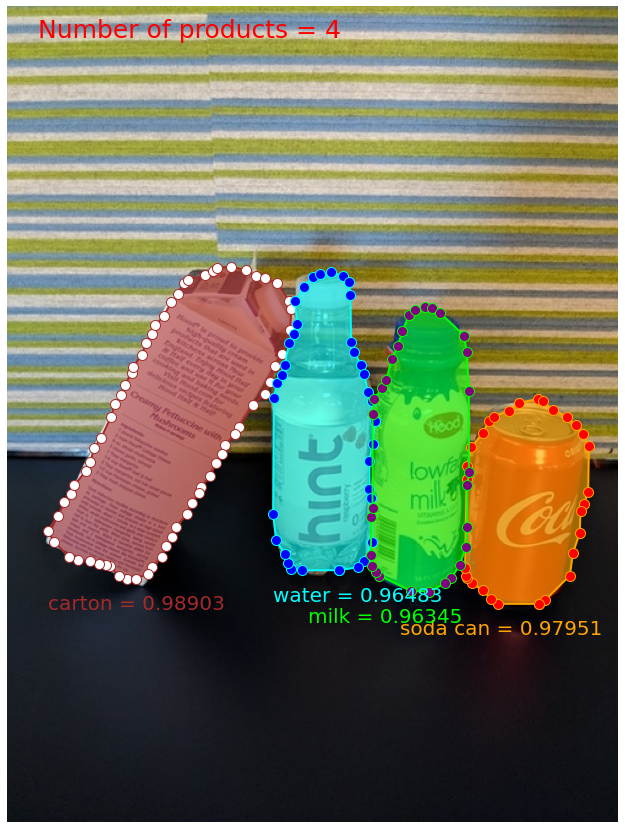

In [11]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "85.jpg")

resp = get_predictions(sample_image)
view_predictions(sample_image, minconf=0.8)